In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import spacy
import nltk
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from collections import Counter
from catboost import CatBoostClassifier


In [4]:
TRAIN_PATH ='data\BBC News Train.csv'
TEST_PATH = 'data\BBC News Test.csv'

In [5]:
df = pd.read_csv(TRAIN_PATH)

# EDA

In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


### Preprocessing and Modelling

In [9]:
df['category_id'] = df['Category'].factorize()[0]

#View first 10 entries of category_id, as a sanity check
df['category_id'][0:10]
df.head(20)

,ArticleId,Text,Category,category_id
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0
5,1582,howard truanted to play snooker conservative...,politics,2
6,651,wales silent on grand slam talk rhys williams ...,sport,3
7,1797,french honour for director parker british film...,entertainment,4
8,2034,car giant hit by mercedes slump a slump in pro...,business,0
9,1866,fockers fuel festive film chart comedy meet th...,entertainment,4


In [10]:
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_id_df

,Category,category_id
0,business,0
3,tech,1
5,politics,2
6,sport,3
7,entertainment,4


In [11]:
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
id_to_category

{0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}

In [12]:
category_to_id

{'business': 0, 'tech': 1, 'politics': 2, 'sport': 3, 'entertainment': 4}

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

Xtrain_tfidf  = tfidf.fit_transform(df.Text).toarray() # Remaps the words in the 1490 articles in the text column of 
                                                  # data frame into features (superset of words) with an importance assigned 
                                                  # based on each words frequency in the document and across documents

labels = df.category_id                           # represents the category of each of the 1490 articles

In [40]:
labels

0       0
1       0
2       0
3       1
4       0
       ..
1485    4
1486    4
1487    0
1488    1
1489    1
Name: category_id, Length: 1490, dtype: int64

In [42]:
Xtrain_tfidf.shape # How many features are there 

(1490, 9927)

In [16]:
category_to_id.items()


dict_items([('business', 0), ('tech', 1), ('politics', 2), ('sport', 3), ('entertainment', 4)])

In [17]:
sorted(category_to_id.items())

[('business', 0),
 ('entertainment', 4),
 ('politics', 2),
 ('sport', 3),
 ('tech', 1)]

In [43]:
Xtrain_tfidf #our tfidf features

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03250994, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03842857, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [44]:
from sklearn.feature_selection import chi2
N = 3  # We are going to look for top 3 categories

#For each category, find words that are highly corelated to it
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(Xtrain_tfidf, labels == category_id)                   # Do chi2 analyses of all items in this category
  indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
  feature_names = np.array(tfidf.get_feature_names_out())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
  print("# '{}':".format(Category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

# 'business':
  . Most correlated unigrams:
       . growth
       . bank
       . shares
  . Most correlated bigrams:
       . stock market
       . economic growth
       . analysts said
# 'entertainment':
  . Most correlated unigrams:
       . singer
       . actor
       . film
  . Most correlated bigrams:
       . won best
       . los angeles
       . box office
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . prime minister
       . tony blair
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . match
       . coach
       . cup
  . Most correlated bigrams:
       . grand slam
       . champions league
       . australian open
# 'tech':
  . Most correlated unigrams:
       . technology
       . software
       . users
  . Most correlated bigrams:
       . anti virus
       . mobile phones
       . mobile phone


In [20]:
features_chi2

(array([0.13345481, 0.01563765, 0.00108776, ..., 0.00812363, 0.15434356,
        0.120306  ]),
 array([0.71487652, 0.9004835 , 0.97368962, ..., 0.92818297, 0.69441858,
        0.72870284]))

In [45]:
from sklearn.manifold import TSNE

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(Xtrain_tfidf) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(Xtrain_tfidf)), size=SAMPLE_SIZE, replace=False)          # Randomly select 30 % of samples
projected_features = TSNE(n_components=3, random_state=0).fit_transform(Xtrain_tfidf[indices]) # Array of all projected features of 30% of Randomly chosen samples 
projected_features.shape

(447, 3)

In [46]:
colors = ['red', 'green', 'midnightblue', 'orange', 'cyan']


In [47]:
import plotly.express as px


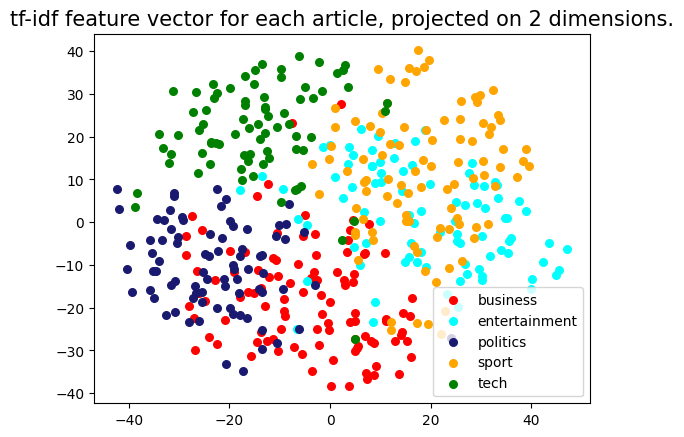

In [48]:
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

# CV

In [ ]:
models = [LogisticRegression(n_jobs=-1, random_state=30),
           SGDClassifier(n_jobs=-1),
           RidgeClassifier(), 
           MultinomialNB(), 
           SVC(),
           RandomForestClassifier(n_estimators=200), 
           GradientBoostingClassifier()]

In [ ]:
CV = 5  # Cross Validate with 5 different folds of 20% data ( 80-20 split with 5 folds )

#Create a data frame that will store the results for all 5 trials of the 3 different models
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = [] # Initially all entries are empty

In [ ]:
#For each Algorithm 
for model in models:
  model_name = model.__class__.__name__
  # create 5 models with different 20% test sets, and store their accuracies
  accuracies = cross_val_score(model, Xtrain_tfidf, labels, scoring='accuracy', cv=CV)
  # Append all 5 accuracies into the entries list ( after all 3 models are run, there will be 3x5 = 15 entries)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

In [ ]:
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

<AxesSubplot: xlabel='model_name', ylabel='accuracy'>

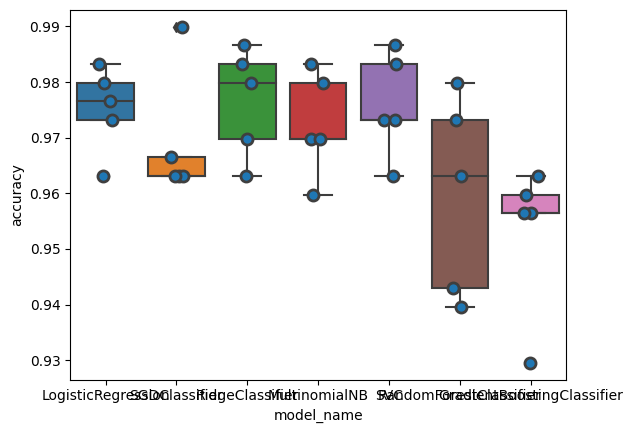

In [ ]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
GradientBoostingClassifier    0.953020
LogisticRegression            0.975168
MultinomialNB                 0.972483
RandomForestClassifier        0.959732
RidgeClassifier               0.976510
SGDClassifier                 0.969128
SVC                           0.975839
Name: accuracy, dtype: float64

In [ ]:
cv_df


,model_name,fold_idx,accuracy
0,LogisticRegression,0,0.973154
1,LogisticRegression,1,0.963087
2,LogisticRegression,2,0.983221
3,LogisticRegression,3,0.979866
4,LogisticRegression,4,0.976510
5,SGDClassifier,0,0.963087
6,SGDClassifier,1,0.963087
7,SGDClassifier,2,0.966443
8,SGDClassifier,3,0.989933
9,SGDClassifier,4,0.963087


In [26]:
df

,ArticleId,Text,Category,category_id
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0
...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,4
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,4
1487,1590,weak dollar hits reuters revenues at media gro...,business,0
1488,1587,apple ipod family expands market apple has exp...,tech,1


In [49]:
X_train, X_test, y_train, y_test= train_test_split(Xtrain_tfidf, labels, test_size=0.25, random_state=0)


Logistic Regression Accuracy : 97.59%
[[84  0  0  2  0]
 [ 1 63  0  0  3]
 [ 0  0 61  1  1]
 [ 0  0  0 84  0]
 [ 0  0  1  0 72]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        86
           1       1.00      0.94      0.97        67
           2       0.98      0.97      0.98        63
           3       0.97      1.00      0.98        84
           4       0.95      0.99      0.97        73

    accuracy                           0.98       373
   macro avg       0.98      0.97      0.98       373
weighted avg       0.98      0.98      0.98       373



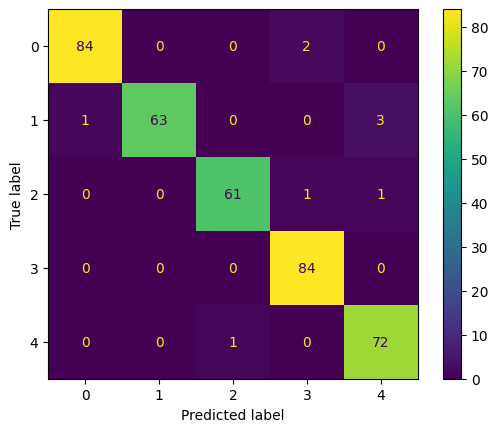

In [57]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix

import sklearn.metrics as metrics
from sklearn.naive_bayes import MultinomialNB
lr = LogisticRegression()
lr.fit(X_train,y_train)
p1=lr.predict(X_test)
s1=accuracy_score(y_test,p1)
print("Logistic Regression Accuracy :", "{:.2f}%".format(100*s1))
# plot_confusion_matrix(lr, X_test, y_test,cmap = 'Blues')
# plt.grid(False)
print(confusion_matrix(y_test, p1))
print(metrics.classification_report(y_test, p1))

# <<<<<<<<<<<<<<<<<<<<<<<<<<<CONFUSION MATRIIX>>>>>>>>>>>>>>>>>>>>>>>>>>>>

import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, p1)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [28]:
# Train Test Split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

model = RandomForestClassifier()
model.fit(X_train,y_train)
predicted_train = model.predict(X_train)
predicted_test = model.predict(X_test)

from sklearn.metrics import classification_report
print (classification_report(y_test,predicted_test))


              precision    recall  f1-score   support

           0       0.98      0.95      0.96        86
           1       0.97      0.90      0.93        67
           2       0.95      0.97      0.96        63
           3       0.92      0.99      0.95        84
           4       0.95      0.95      0.95        73

    accuracy                           0.95       373
   macro avg       0.95      0.95      0.95       373
weighted avg       0.95      0.95      0.95       373



In [37]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.naive_bayes import MultinomialNB
lr = LogisticRegression()
lr.fit(Xtrain_count,ytrain)
p1=lr.predict(Xtest_count)
s1=accuracy_score(ytest,p1)
print("Logistic Regression Accuracy :", "{:.2f}%".format(100*s1))
plot_confusion_matrix(lr, Xtest_count, ytest,cmap = 'Blues')
plt.grid(False)
print(confusion_matrix(ytest, p1))
print(metrics.classification_report(ytest, p1))

Logistic Regression Accuracy : 97.59%
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        86
           1       0.97      0.90      0.93        67
           2       0.95      0.97      0.96        63
           3       0.92      0.99      0.95        84
           4       0.95      0.95      0.95        73

    accuracy                           0.95       373
   macro avg       0.95      0.95      0.95       373
weighted avg       0.95      0.95      0.95       373

